In [1]:
# Import libraries needed for the analysis
import os
import pandas as pd
import numpy as np

from datetime import datetime
import random
import string

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk

In [2]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 5
from numpy.random import seed
seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
# Read the training and test datasets
train_tweets= pd.read_csv('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/train.csv')
test_tweets=pd.read_csv('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/test.csv')

In [4]:
train_tweets.shape

(7613, 5)

In [5]:
test_tweets.shape

(3263, 4)

In [6]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
train_tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
#Create a dataframe to store the model accuracy and scores
results_tbl = pd.DataFrame(columns=['Model_name','vocabulary size (factor1)', 'pre-trained vector dimensions (factor2)','RNN structure (factor3)','hyperparameter dropout (factor4)','Processing Time','Training Set Accuracy','Validation Set Accuracy','Test Set F1-score (Kaggle score)'])
results_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Model_name                               0 non-null      object
 1   vocabulary size (factor1)                0 non-null      object
 2   pre-trained vector dimensions (factor2)  0 non-null      object
 3   RNN structure (factor3)                  0 non-null      object
 4   hyperparameter dropout (factor4)         0 non-null      object
 5   Processing Time                          0 non-null      object
 6   Training Set Accuracy                    0 non-null      object
 7   Validation Set Accuracy                  0 non-null      object
 8   Test Set F1-score (Kaggle score)         0 non-null      object
dtypes: object(9)
memory usage: 0.0+ bytes


# Exploratory Data Analysis & Data Preparation

/Users/harini-mac/Desktop/Northwestern University/MSDS-422/my_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'target count plot in the training data (0 - not a real disaster, 1 - a real disaster)')

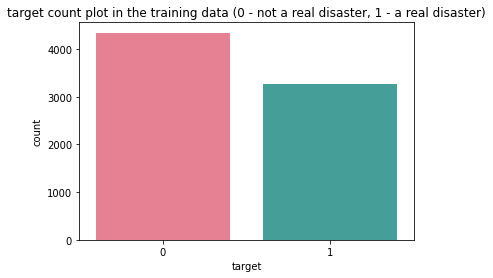

In [10]:
# Count plot of the targets in training data 
sns.countplot(train_tweets['target'], palette="husl")
plt.title('target count plot in the training data (0 - not a real disaster, 1 - a real disaster)')

In [11]:
# check for any null values 
# the variable of interest in the data is text.
train_tweets.isna().sum() 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

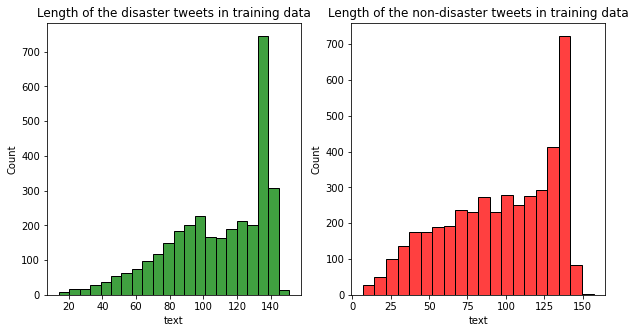

In [12]:
# Distribution of the length of the tweets in the training data
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
disaster_tweets_len=train_tweets[train_tweets['target']==1]['text'].str.len()
nondisaster_tweets_len=train_tweets[train_tweets['target']==0]['text'].str.len()
sns.histplot(disaster_tweets_len, ax=ax1, color="g")
ax1.set_title('Length of the disaster tweets in training data')
sns.histplot(nondisaster_tweets_len, ax=ax2, color="r")
ax2.set_title('Length of the non-disaster tweets in training data')
plt.show()

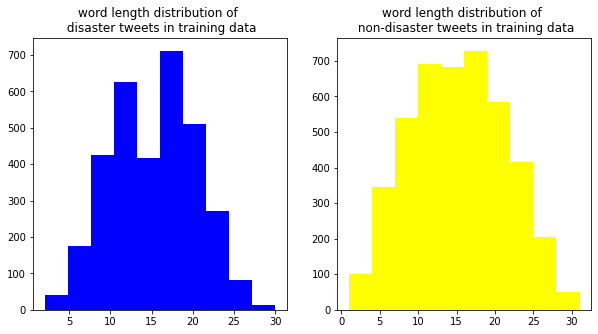

In [13]:
# Distribution of the word lengths of the tweets in the  training data
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
diaster_tweet_lengths=train_tweets[train_tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(diaster_tweet_lengths,color='blue')
ax1.set_title('word length distribution of \n disaster tweets in training data')
nondisaster_tweet_lengths=train_tweets[train_tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(nondisaster_tweet_lengths,color='yellow')
ax2.set_title('word length distribution of \n non-disaster tweets in training data')
plt.show()

# Read function for the  GloVe (global vectors) 

In [14]:
#reading from the file to turn the words to word embedding vector
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

## Read the Glove file - glove.6B.50d.txt

In [15]:
#reading from the file to learn the word embedding into the list word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/embeddings/gloVe.6B/glove.6B.50d.txt')

In [16]:
len(word_to_index)

400000

In [17]:
len(word_to_vec_map)

400000

In [18]:
len(index_to_word)

400000

## Cleanse the training and test data 
## Use the word_to_vec_map from glove.6B.50d

In [19]:
def clean(text):
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', text).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word not in word_to_vec_map:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

In [20]:
for i in range (train_tweets.shape[0]):
    train_tweets.at[i,'text']=clean(train_tweets.loc[i,'text'])
    
for i in range(test_tweets.shape[0]):
    test_tweets.at[i,'text']=clean(test_tweets.loc[i,'text'])

In [21]:
train_text = train_tweets['text']
test_text = test_tweets['text']

# Encode the text in the training data
# Pad the resultant sequences

In [22]:
# https://stackoverflow.com/questions/57693333/processing-before-or-after-train-test-split
# https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [23]:
train_sequences = tokenizer.texts_to_sequences(train_text)

In [24]:
tokenizer.texts_to_sequences(["Forest fire near La Ronge Sask. Canada"])

[[178, 42, 214, 664, 6037, 6038, 1319]]

In [25]:
tokenizer.sequences_to_texts([[178, 42, 214, 664, 6037, 6038, 1319]])

['forest fire near la ronge sask canada']

In [26]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index))

Number of unique tokens :  12256


In [27]:
dataset_size = tokenizer.document_count
dataset_size

7613

In [28]:
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen

31

In [29]:
padded_seq = keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen)
X_train = padded_seq
Y_train = train_tweets['target']
X_train.shape

(7613, 31)

# Generate embedding matrix for tokens in the training data - 50 Dimensions

In [30]:
embedding_matrix = np.zeros((len(word2index)+1,50))

embedding_vec=[]
for word, i in word2index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec

In [31]:
print(embedding_matrix[1])

[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [32]:
print(embedding_matrix.shape)

(12257, 50)


# Fit RNN 1
# vocabulary size (factor 1): 400K
# pre-trained vector dimensions (factor 2): GloVe.6B.50d
# rnn structure (factor 3): LSTM layer based structure
# dropout (factor 4): 0.1

In [33]:
model1 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [34]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 50)            612850    
_________________________________________________________________
lstm (LSTM)                  (None, 31, 128)           91648     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 756,019
Trainable params: 143,169
Non-trainable params: 612,850
_________________________________________________________________


In [35]:
opt=Adam(learning_rate=1e-5)
model1.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [36]:
# Fit the model; obtain the model fit time
start=datetime.now()
history1 = model1.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 9s 52ms/step - loss: 0.6899 - accuracy: 0.5241 - val_loss: 0.6809 - val_accuracy: 0.5976
Epoch 2/40
167/167 [==============================] - 8s 51ms/step - loss: 0.6698 - accuracy: 0.6632 - val_loss: 0.6575 - val_accuracy: 0.7102
Epoch 3/40
167/167 [==============================] - 9s 54ms/step - loss: 0.6475 - accuracy: 0.7251 - val_loss: 0.6303 - val_accuracy: 0.7688
Epoch 4/40
167/167 [==============================] - 9s 53ms/step - loss: 0.6207 - accuracy: 0.7647 - val_loss: 0.5968 - val_accuracy: 0.7723
Epoch 5/40
167/167 [==============================] - 9s 56ms/step - loss: 0.5883 - accuracy: 0.7658 - val_loss: 0.5619 - val_accuracy: 0.7859
Epoch 6/40
167/167 [==============================] - 9s 54ms/step - loss: 0.5587 - accuracy: 0.7696 - val_loss: 0.5316 - val_accuracy: 0.7806
Epoch 7/40
167/167 [==============================] - 9s 53ms/step - loss: 0.5340 - accuracy: 0.7699 - val_loss: 0.5129 - val_accuracy: 0.7815

In [37]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history1.history['accuracy'][np.argmin(history1.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.794

In [38]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history1.history['val_accuracy'][np.argmin(history1.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.803

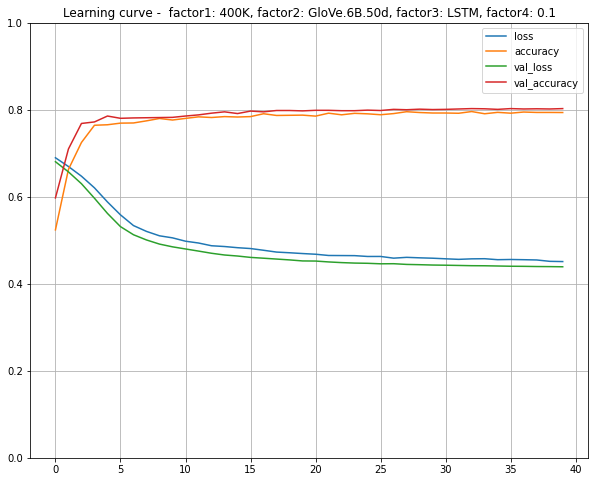

In [39]:
# Plot the learning curve
pd.DataFrame(history1.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve -  factor1: 400K, factor2: GloVe.6B.50d, factor3: LSTM, factor4: 0.1')
plt.show()

# Prepare the test data

In [40]:
test_sequences = tokenizer.texts_to_sequences(test_text)
padded_seq = keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen)
X_test = padded_seq
X_test.shape

(3263, 31)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [41]:
predict1 = model1.predict_classes(X_test)
predict1

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [42]:
len(predict1)

3263

In [43]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict1)})
submission_df.to_csv('submission_rnn_1.csv',index=False)

In [44]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #1', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector dimensions (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78087'
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.794,0.803,0.78087


# Fit RNN 2
# vocabulary size (factor 1): 400K
# pre-trained vector dimensions (factor 2): GloVe.6B.50d
# rnn structure (factor 3): LSTM layer based structure
# dropout (factor 4): 0.3

In [45]:
model2 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [46]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 50)            612850    
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 128)           91648     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 756,019
Trainable params: 143,169
Non-trainable params: 612,850
_________________________________________________________________


In [47]:
opt=Adam(learning_rate=1e-5)
model2.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [48]:
# Fit the model; obtain the model fit time
start=datetime.now()
history2 = model2.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 9s 53ms/step - loss: 0.6938 - accuracy: 0.4873 - val_loss: 0.6733 - val_accuracy: 0.6979
Epoch 2/40
167/167 [==============================] - 9s 51ms/step - loss: 0.6711 - accuracy: 0.6735 - val_loss: 0.6511 - val_accuracy: 0.7329
Epoch 3/40
167/167 [==============================] - 9s 54ms/step - loss: 0.6499 - accuracy: 0.7121 - val_loss: 0.6224 - val_accuracy: 0.7636
Epoch 4/40
167/167 [==============================] - 10s 61ms/step - loss: 0.6242 - accuracy: 0.7318 - val_loss: 0.5883 - val_accuracy: 0.7750
Epoch 5/40
167/167 [==============================] - 9s 54ms/step - loss: 0.5936 - accuracy: 0.7448 - val_loss: 0.5548 - val_accuracy: 0.7776
Epoch 6/40
167/167 [==============================] - 8s 50ms/step - loss: 0.5658 - accuracy: 0.7555 - val_loss: 0.5249 - val_accuracy: 0.7771
Epoch 7/40
167/167 [==============================] - 9s 54ms/step - loss: 0.5455 - accuracy: 0.7572 - val_loss: 0.5082 - val_accuracy: 0.785

In [49]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history2.history['accuracy'][np.argmin(history2.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7865

In [50]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history2.history['val_accuracy'][np.argmin(history2.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.7995

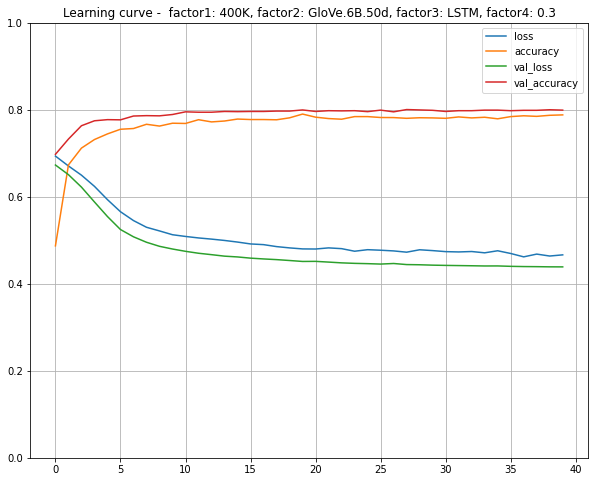

In [51]:
# Plot the learning curve
pd.DataFrame(history2.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve -  factor1: 400K, factor2: GloVe.6B.50d, factor3: LSTM, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier 

In [52]:
X_test.shape

(3263, 31)

In [53]:
X_test

array([[   0,    0,    0, ..., 1840,  121,   86],
       [   0,    0,    0, ...,  607, 1922,  224],
       [   0,    0,    0, ...,  333,   91,   39],
       ...,
       [   0,    0,    0, ...,  340,    3, 1228],
       [   0,    0,    0, ...,  443,  234, 1652],
       [   0,    0,    0, ..., 1520,   72,  257]], dtype=int32)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [54]:
predict2 = model2.predict_classes(X_test)
predict2

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [55]:
len(predict2)

3263

In [56]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict2)})
submission_df.to_csv('submission_rnn_2.csv',index=False)

In [57]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #2', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector dimensions (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78026'
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026


# Fit RNN 3
# vocabulary size (factor 1): 400K
# pre-trained vector dimensions (factor 2): GloVe.6B.50d
# rnn structure (factor 3): GRU layer based structure
# dropout (factor 4): 0.1

In [58]:
model3 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [59]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 31, 50)            612850    
_________________________________________________________________
gru (GRU)                    (None, 31, 128)           69120     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 721,331
Trainable params: 108,481
Non-trainable params: 612,850
_________________________________________________________________


In [60]:
opt=Adam(learning_rate=1e-5)
model3.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [61]:
# Fit the model; obtain the model fit time
start=datetime.now()
history3 = model3.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 7s 44ms/step - loss: 0.6669 - accuracy: 0.6373 - val_loss: 0.6498 - val_accuracy: 0.6511
Epoch 2/40
167/167 [==============================] - 7s 43ms/step - loss: 0.6407 - accuracy: 0.6819 - val_loss: 0.6215 - val_accuracy: 0.7005
Epoch 3/40
167/167 [==============================] - 7s 43ms/step - loss: 0.6164 - accuracy: 0.7165 - val_loss: 0.5924 - val_accuracy: 0.7439
Epoch 4/40
167/167 [==============================] - 7s 41ms/step - loss: 0.5937 - accuracy: 0.7333 - val_loss: 0.5656 - val_accuracy: 0.7588
Epoch 5/40
167/167 [==============================] - 7s 42ms/step - loss: 0.5716 - accuracy: 0.7429 - val_loss: 0.5423 - val_accuracy: 0.7745
Epoch 6/40
167/167 [==============================] - 7s 43ms/step - loss: 0.5532 - accuracy: 0.7476 - val_loss: 0.5234 - val_accuracy: 0.7771
Epoch 7/40
167/167 [==============================] - 7s 41ms/step - loss: 0.5386 - accuracy: 0.7530 - val_loss: 0.5086 - val_accuracy: 0.7806

In [62]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history3.history['accuracy'][np.argmin(history3.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7964

In [63]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history3.history['val_accuracy'][np.argmin(history3.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8043

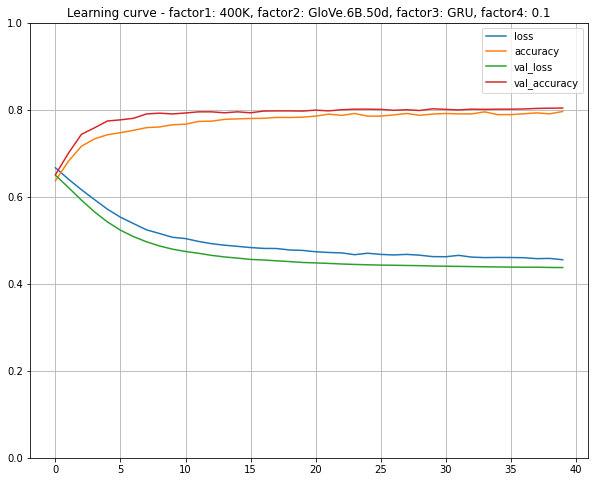

In [64]:
# Plot the learning curve
pd.DataFrame(history3.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.50d, factor3: GRU, factor4: 0.1')
plt.show()

# Re-use the X_test obtained earlier

In [65]:
X_test

array([[   0,    0,    0, ..., 1840,  121,   86],
       [   0,    0,    0, ...,  607, 1922,  224],
       [   0,    0,    0, ...,  333,   91,   39],
       ...,
       [   0,    0,    0, ...,  340,    3, 1228],
       [   0,    0,    0, ...,  443,  234, 1652],
       [   0,    0,    0, ..., 1520,   72,  257]], dtype=int32)

In [66]:
X_test.shape

(3263, 31)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [67]:
predict3 = model3.predict_classes(X_test)
predict3

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [68]:
len(predict3)

3263

In [69]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict3)})
submission_df.to_csv('submission_rnn_3.csv',index=False)

In [70]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #3', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector dimensions (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78302'
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302


# Fit RNN 4
# vocabulary size (factor 1): 400K
# pre-trained vector dimensions (factor 2): GloVe.6B.50d
# rnn structure (factor 3): GRU based structure
# dropout (factor 4): 0.3

In [71]:
model4 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [72]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 31, 50)            612850    
_________________________________________________________________
gru_2 (GRU)                  (None, 31, 128)           69120     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 721,331
Trainable params: 108,481
Non-trainable params: 612,850
_________________________________________________________________


In [73]:
opt=Adam(learning_rate=1e-5)
model4.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [74]:
# Fit the model; obtain the model fit time
start=datetime.now()
history4 = model4.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 7s 44ms/step - loss: 0.6827 - accuracy: 0.5673 - val_loss: 0.6713 - val_accuracy: 0.5827
Epoch 2/40
167/167 [==============================] - 7s 42ms/step - loss: 0.6700 - accuracy: 0.5999 - val_loss: 0.6573 - val_accuracy: 0.5989
Epoch 3/40
167/167 [==============================] - 8s 45ms/step - loss: 0.6556 - accuracy: 0.6375 - val_loss: 0.6410 - val_accuracy: 0.6506
Epoch 4/40
167/167 [==============================] - 8s 47ms/step - loss: 0.6430 - accuracy: 0.6553 - val_loss: 0.6219 - val_accuracy: 0.7040
Epoch 5/40
167/167 [==============================] - 8s 49ms/step - loss: 0.6275 - accuracy: 0.6881 - val_loss: 0.6006 - val_accuracy: 0.7399
Epoch 6/40
167/167 [==============================] - 7s 44ms/step - loss: 0.6108 - accuracy: 0.7093 - val_loss: 0.5789 - val_accuracy: 0.7474
Epoch 7/40
167/167 [==============================] - 7s 43ms/step - loss: 0.5924 - accuracy: 0.7317 - val_loss: 0.5566 - val_accuracy: 0.7618

In [75]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history4.history['accuracy'][np.argmin(history4.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7861

In [76]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history4.history['val_accuracy'][np.argmin(history4.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8034

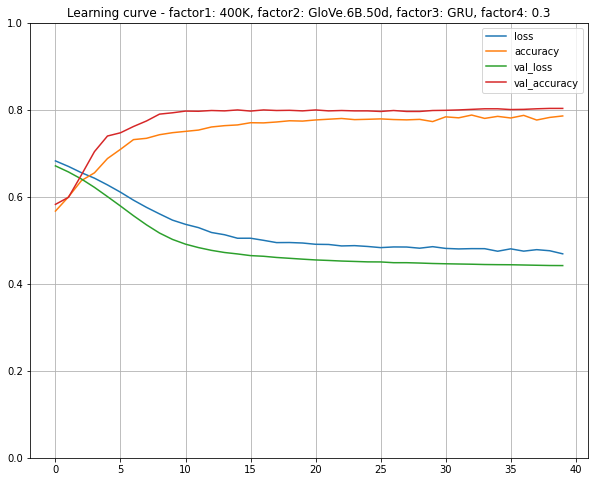

In [77]:
# Plot the learning curve
pd.DataFrame(history4.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.50d, factor3: GRU, factor4: 0.3')
plt.show()


# Re-use the X_test obtained earlier

In [78]:
X_test

array([[   0,    0,    0, ..., 1840,  121,   86],
       [   0,    0,    0, ...,  607, 1922,  224],
       [   0,    0,    0, ...,  333,   91,   39],
       ...,
       [   0,    0,    0, ...,  340,    3, 1228],
       [   0,    0,    0, ...,  443,  234, 1652],
       [   0,    0,    0, ..., 1520,   72,  257]], dtype=int32)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [79]:
predict4 = model4.predict_classes(X_test)
predict4


array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]], dtype=int32)

In [80]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict4)})
submission_df.to_csv('submission_rnn_4.csv',index=False)


In [81]:

#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #4', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector dimensions (factor2)':'GloVe.6B.50d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.77873'
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873


## Read the Glove file - gloVe.6B.200d.txt

In [82]:
#reading from the file to learn the word embedding into the list word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/embeddings/gloVe.6B/glove.6B.200d.txt')


In [83]:
len(word_to_index)

400000

In [84]:
len(word_to_vec_map)

400000

In [85]:
len(index_to_word)

400000

## Cleanse the training and test data 
## Use the word_to_vec_map from glove.6B.200d

In [86]:
# clean the training and test data using the glove.6B.200d word_to_vec_map
for i in range (train_tweets.shape[0]):
    train_tweets.at[i,'text']=clean(train_tweets.loc[i,'text'])
    
for i in range(test_tweets.shape[0]):
    test_tweets.at[i,'text']=clean(test_tweets.loc[i,'text'])

In [87]:
train_text = train_tweets['text']
test_text = test_tweets['text']

# Encode the text in the training data
# Pad the resultant sequences

In [88]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [89]:

train_sequences = tokenizer.texts_to_sequences(train_text)

In [90]:
tokenizer.texts_to_sequences(["Forest fire near La Ronge Sask. Canada"])

[[178, 42, 214, 664, 6037, 6038, 1319]]

In [91]:
tokenizer.sequences_to_texts([[178, 42, 214, 664, 6037, 6038, 1319]])

['forest fire near la ronge sask canada']

In [92]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index))

Number of unique tokens :  12256


In [93]:

dataset_size = tokenizer.document_count
dataset_size

7613

In [94]:
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen


31

In [95]:
padded_seq = keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen)
X_train = padded_seq
Y_train = train_tweets['target']
X_train.shape


(7613, 31)

# Generate embedding matrix for tokens in the training data - 200 Dimensions

In [96]:
embedding_matrix = np.zeros((len(word2index)+1,200))

embedding_vec=[]
for word, i in word2index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec


In [97]:
print(embedding_matrix[1])

[-7.1549e-02  9.3459e-02  2.3738e-02 -9.0339e-02  5.6123e-02  3.2547e-01
 -3.9796e-01 -9.2139e-02  6.1181e-02 -1.8950e-01  1.3061e-01  1.4349e-01
  1.1479e-02  3.8158e-01  5.4030e-01 -1.4088e-01  2.4315e-01  2.3036e-01
 -5.5339e-01  4.8154e-02  4.5662e-01  3.2338e+00  2.0199e-02  4.9019e-02
 -1.4132e-02  7.6017e-02 -1.1527e-01  2.0060e-01 -7.7657e-02  2.4328e-01
  1.6368e-01 -3.4118e-01 -6.6070e-02  1.0152e-01  3.8232e-02 -1.7668e-01
 -8.8153e-01 -3.3895e-01 -3.5481e-02 -5.5095e-01 -1.6899e-02 -4.3982e-01
  3.9004e-02  4.0447e-01 -2.5880e-01  6.4594e-01  2.6641e-01  2.8009e-01
 -2.4625e-02  6.3302e-01 -3.1700e-01  1.0271e-01  3.0886e-01  9.7792e-02
 -3.8227e-01  8.6552e-02  4.7075e-02  2.3511e-01 -3.2127e-01 -2.8538e-01
  1.6670e-01 -4.9707e-03 -6.2714e-01 -2.4904e-01  2.9713e-01  1.4379e-01
 -1.2325e-01 -5.8178e-02 -1.0290e-03 -8.2126e-02  3.6935e-01 -5.8442e-04
  3.4286e-01  2.8426e-01 -6.8599e-02  6.5747e-01 -2.9087e-02  1.6184e-01
  7.3672e-02 -3.0343e-01  9.5733e-02 -5.2860e-01 -2

In [98]:
print(embedding_matrix.shape)

(12257, 200)


# Fit RNN 5
# vocabulary size (factor 1): 400K
# pre-trained vector dimensions (factor 2): GloVe.6B.200d
# rnn structure (factor 3): LSTM layer based structure
# dropout (factor 4): 0.1

In [99]:
model5 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [100]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 31, 128)           168448    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 2,671,369
Trainable params: 219,969
Non-trainable params: 2,451,400
_________________________________________________________________


In [101]:
opt=Adam(learning_rate=1e-5)
model5.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [102]:
# Fit the model; obtain the model fit time
start=datetime.now()
history5 = model5.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.1
)
end=datetime.now()
print(end-start)

Epoch 1/40
215/215 [==============================] - 14s 66ms/step - loss: 0.6745 - accuracy: 0.5754 - val_loss: 0.6688 - val_accuracy: 0.5433
Epoch 2/40
215/215 [==============================] - 13s 61ms/step - loss: 0.6467 - accuracy: 0.6236 - val_loss: 0.6341 - val_accuracy: 0.6234
Epoch 3/40
215/215 [==============================] - 12s 58ms/step - loss: 0.6098 - accuracy: 0.7249 - val_loss: 0.5899 - val_accuracy: 0.7572
Epoch 4/40
215/215 [==============================] - 13s 59ms/step - loss: 0.5708 - accuracy: 0.7592 - val_loss: 0.5453 - val_accuracy: 0.7782
Epoch 5/40
215/215 [==============================] - 12s 54ms/step - loss: 0.5399 - accuracy: 0.7695 - val_loss: 0.5198 - val_accuracy: 0.7835
Epoch 6/40
215/215 [==============================] - 11s 50ms/step - loss: 0.5191 - accuracy: 0.7800 - val_loss: 0.5013 - val_accuracy: 0.7927
Epoch 7/40
215/215 [==============================] - 13s 62ms/step - loss: 0.5048 - accuracy: 0.7815 - val_loss: 0.4878 - val_accuracy:

In [103]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history5.history['accuracy'][np.argmin(history5.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8194

In [104]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history5.history['val_accuracy'][np.argmin(history5.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8084

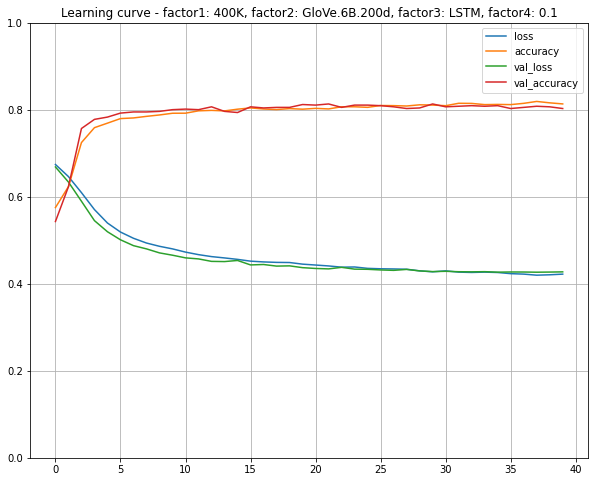

In [105]:

# Plot the learning curve
pd.DataFrame(history5.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: LSTM, factor4: 0.1')
plt.show()

# Prepare the test data

In [106]:
test_sequences = tokenizer.texts_to_sequences(test_text)
padded_seq = keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen)
X_test = padded_seq
X_test.shape

(3263, 31)

In [107]:

predict5 = model5.predict_classes(X_test)
predict5

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [108]:
len(predict5)

3263

In [109]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict5)})
submission_df.to_csv('submission_rnn_5.csv',index=False)


In [110]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #5', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector dimensions (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.79313'
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313


# Fit RNN 6
# vocabulary size (factor 1): 400K
# pre-trained vector dimensions (factor 2): GloVe.6B.200d
# rnn structure (factor 3): LSTM layer based structure
# dropout (factor 4): 0.3


In [111]:
model6 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [112]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 31, 128)           168448    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 2,671,369
Trainable params: 219,969
Non-trainable params: 2,451,400
_________________________________________________________________


In [113]:
opt=Adam(learning_rate=1e-5)
model6.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [114]:
# Fit the model; obtain the model fit time
start=datetime.now()
history6 = model6.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 10s 62ms/step - loss: 0.6838 - accuracy: 0.5889 - val_loss: 0.6704 - val_accuracy: 0.6410
Epoch 2/40
167/167 [==============================] - 11s 67ms/step - loss: 0.6572 - accuracy: 0.6598 - val_loss: 0.6395 - val_accuracy: 0.6589
Epoch 3/40
167/167 [==============================] - 10s 60ms/step - loss: 0.6303 - accuracy: 0.6924 - val_loss: 0.6057 - val_accuracy: 0.7447
Epoch 4/40
167/167 [==============================] - 10s 59ms/step - loss: 0.6014 - accuracy: 0.7375 - val_loss: 0.5735 - val_accuracy: 0.7706
Epoch 5/40
167/167 [==============================] - 10s 60ms/step - loss: 0.5767 - accuracy: 0.7591 - val_loss: 0.5484 - val_accuracy: 0.7736
Epoch 6/40
167/167 [==============================] - 10s 63ms/step - loss: 0.5569 - accuracy: 0.7592 - val_loss: 0.5277 - val_accuracy: 0.7802
Epoch 7/40
167/167 [==============================] - 10s 61ms/step - loss: 0.5401 - accuracy: 0.7598 - val_loss: 0.5127 - val_accuracy:

In [115]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history6.history['accuracy'][np.argmin(history6.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8

In [116]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history6.history['val_accuracy'][np.argmin(history6.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.813

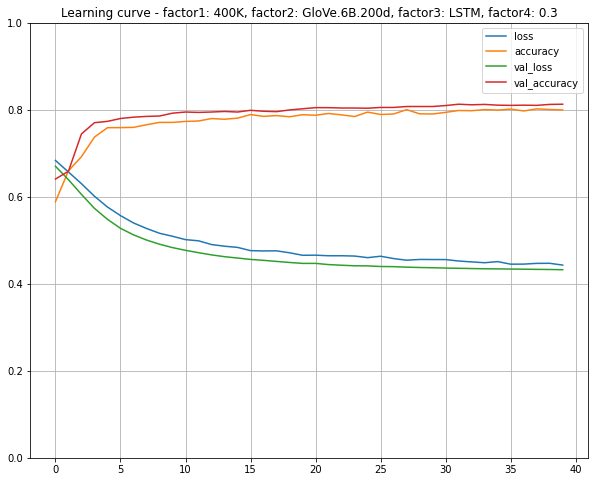

In [117]:

# Plot the learning curve
pd.DataFrame(history6.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: LSTM, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier 

In [118]:
X_test.shape

(3263, 31)

In [119]:
X_test

array([[   0,    0,    0, ..., 1840,  121,   86],
       [   0,    0,    0, ...,  607, 1922,  224],
       [   0,    0,    0, ...,  333,   91,   39],
       ...,
       [   0,    0,    0, ...,  340,    3, 1228],
       [   0,    0,    0, ...,  443,  234, 1652],
       [   0,    0,    0, ..., 1520,   72,  257]], dtype=int32)

In [120]:
# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [121]:

predict6 = model6.predict_classes(X_test)
predict6

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [122]:
len(predict6)

3263

In [123]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict6)})
submission_df.to_csv('submission_rnn_6.csv',index=False)


In [124]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #6', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector dimensions (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78639'
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639


# Fit RNN 7
# vocabulary size (factor 1): 400K
# pre-trained vector dimensions (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU layer based structure
# dropout (factor 4): 0.1


In [125]:

model7 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [126]:
model7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
gru_4 (GRU)                  (None, 31, 128)           126720    
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 2,617,481
Trainable params: 166,081
Non-trainable params: 2,451,400
_________________________________________________________________


In [127]:
opt=Adam(learning_rate=1e-5)
model7.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [128]:
# Fit the model; obtain the model fit time
start=datetime.now()
history7 = model7.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)



Epoch 1/40
167/167 [==============================] - 9s 54ms/step - loss: 0.6793 - accuracy: 0.5740 - val_loss: 0.6668 - val_accuracy: 0.6178
Epoch 2/40
167/167 [==============================] - 8s 49ms/step - loss: 0.6622 - accuracy: 0.6204 - val_loss: 0.6467 - val_accuracy: 0.6694
Epoch 3/40
167/167 [==============================] - 8s 49ms/step - loss: 0.6442 - accuracy: 0.6545 - val_loss: 0.6253 - val_accuracy: 0.7049
Epoch 4/40
167/167 [==============================] - 8s 51ms/step - loss: 0.6249 - accuracy: 0.6911 - val_loss: 0.6025 - val_accuracy: 0.7215
Epoch 5/40
167/167 [==============================] - 9s 57ms/step - loss: 0.6028 - accuracy: 0.7210 - val_loss: 0.5795 - val_accuracy: 0.7443
Epoch 6/40
167/167 [==============================] - 9s 54ms/step - loss: 0.5838 - accuracy: 0.7339 - val_loss: 0.5582 - val_accuracy: 0.7474
Epoch 7/40
167/167 [==============================] - 9s 52ms/step - loss: 0.5646 - accuracy: 0.7386 - val_loss: 0.5397 - val_accuracy: 0.7544

In [129]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history7.history['accuracy'][np.argmin(history7.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.8127

In [130]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history7.history['val_accuracy'][np.argmin(history7.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.7947

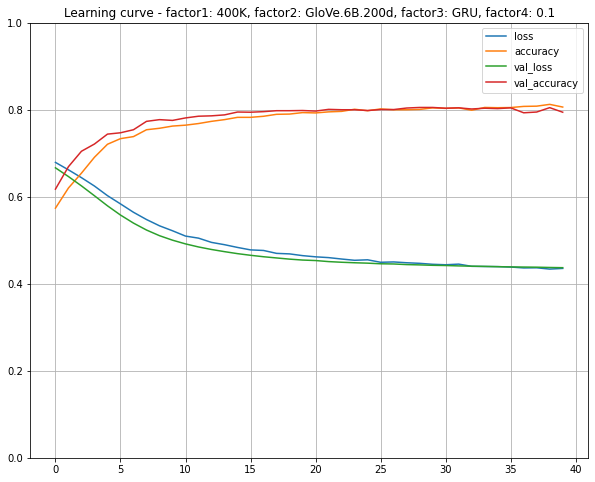

In [131]:
# Plot the learning curve
pd.DataFrame(history7.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: GRU, factor4: 0.1')
plt.show()


In [132]:
# Re-use the X_test obtained earlier

In [133]:
X_test

array([[   0,    0,    0, ..., 1840,  121,   86],
       [   0,    0,    0, ...,  607, 1922,  224],
       [   0,    0,    0, ...,  333,   91,   39],
       ...,
       [   0,    0,    0, ...,  340,    3, 1228],
       [   0,    0,    0, ...,  443,  234, 1652],
       [   0,    0,    0, ..., 1520,   72,  257]], dtype=int32)

In [134]:
X_test.shape

(3263, 31)

# Make the prediction on the test data

# 1 - disaster tweet , 0 - non-disaster tweet


In [135]:

predict7 = model7.predict_classes(X_test)
predict7

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [136]:
len(predict7)

3263

In [137]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict7)})
submission_df.to_csv('submission_rnn_7.csv',index=False)

In [138]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #7', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector dimensions (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.79068'
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068


# Fit RNN 8
# vocabulary size (factor 1): 400K
# pre-trained vector dimensions (factor 2): GloVe.6B.200d
# rnn structure (factor 3): GRU based structure
# dropout (factor 4): 0.3

In [139]:
model8 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])


In [140]:
model8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 31, 200)           2451400   
_________________________________________________________________
gru_6 (GRU)                  (None, 31, 128)           126720    
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 2,617,481
Trainable params: 166,081
Non-trainable params: 2,451,400
_________________________________________________________________


In [141]:
opt=Adam(learning_rate=1e-5)
model8.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)


In [142]:

# Fit the model; obtain the model fit time
start=datetime.now()
history8 = model8.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 9s 55ms/step - loss: 0.6833 - accuracy: 0.5686 - val_loss: 0.6797 - val_accuracy: 0.5582
Epoch 2/40
167/167 [==============================] - 9s 53ms/step - loss: 0.6727 - accuracy: 0.5823 - val_loss: 0.6665 - val_accuracy: 0.5617
Epoch 3/40
167/167 [==============================] - 9s 53ms/step - loss: 0.6605 - accuracy: 0.5947 - val_loss: 0.6528 - val_accuracy: 0.5867
Epoch 4/40
167/167 [==============================] - 8s 49ms/step - loss: 0.6470 - accuracy: 0.6234 - val_loss: 0.6384 - val_accuracy: 0.6300
Epoch 5/40
167/167 [==============================] - 8s 49ms/step - loss: 0.6371 - accuracy: 0.6448 - val_loss: 0.6231 - val_accuracy: 0.6756
Epoch 6/40
167/167 [==============================] - 8s 48ms/step - loss: 0.6248 - accuracy: 0.6669 - val_loss: 0.6078 - val_accuracy: 0.7075
Epoch 7/40
167/167 [==============================] - 8s 48ms/step - loss: 0.6121 - accuracy: 0.6951 - val_loss: 0.5926 - val_accuracy: 0.7259

In [143]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history8.history['accuracy'][np.argmin(history8.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7919

In [144]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history8.history['val_accuracy'][np.argmin(history8.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8008

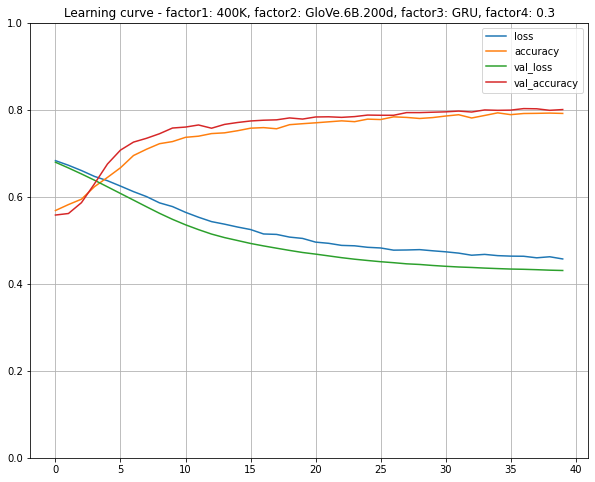

In [145]:
# Plot the learning curve
pd.DataFrame(history8.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 400K, factor2: GloVe.6B.200d, factor3: GRU, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier

In [146]:
X_test

array([[   0,    0,    0, ..., 1840,  121,   86],
       [   0,    0,    0, ...,  607, 1922,  224],
       [   0,    0,    0, ...,  333,   91,   39],
       ...,
       [   0,    0,    0, ...,  340,    3, 1228],
       [   0,    0,    0, ...,  443,  234, 1652],
       [   0,    0,    0, ..., 1520,   72,  257]], dtype=int32)

In [147]:
X_test.shape

(3263, 31)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [148]:
predict8 = model8.predict_classes(X_test)
predict8


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [149]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict8)})
submission_df.to_csv('submission_rnn_8.csv',index=False)


In [150]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #8', 
                                   'vocabulary size (factor1)':'400K',
                                   'pre-trained vector dimensions (factor2)':'GloVe.6B.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78608'
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608


## Read the Glove file - glove.twitter.27B.50d.txt

In [151]:

#reading from the file to learn the word embedding into the list word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/embeddings/glove.twitter.27B/glove.twitter.27B.50d.txt')


In [152]:
len(word_to_index)

1193514

In [153]:
len(word_to_vec_map)

1193514

In [154]:
len(index_to_word)

1193514

## Cleanse the training and test data 
## Use the word_to_vec_map from glove.twitter.27B.50d

In [155]:
for i in range (train_tweets.shape[0]):
    train_tweets.at[i,'text']=clean(train_tweets.loc[i,'text'])
    
for i in range(test_tweets.shape[0]):
    test_tweets.at[i,'text']=clean(test_tweets.loc[i,'text'])


In [156]:

train_text = train_tweets['text']
test_text = test_tweets['text']

# Encode the text in the training data
# Pad the resultant sequences

In [157]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [158]:
train_sequences = tokenizer.texts_to_sequences(train_text)

In [159]:
tokenizer.texts_to_sequences(["Forest fire near La Ronge Sask. Canada"])

[[175, 42, 208, 649, 5804, 5805, 1279]]

In [160]:
tokenizer.sequences_to_texts([[175, 42, 208, 649, 5804, 5805, 1279]])

['forest fire near la ronge sask canada']

In [161]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index))

Number of unique tokens :  11540


In [162]:
dataset_size = tokenizer.document_count
dataset_size

7613

In [163]:
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen

31

In [164]:
padded_seq = keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen)
X_train = padded_seq
Y_train = train_tweets['target']
X_train.shape


(7613, 31)

# Generate embedding matrix for tokens in the training data - 50 Dimensions

In [165]:
embedding_matrix = np.zeros((len(word2index)+1,50))

embedding_vec=[]
for word, i in word2index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec

In [166]:
print(embedding_matrix[1])

[ 2.5320e-01 -1.4884e-02  5.9371e-01  1.5902e-01  1.2754e-01  2.2428e-01
  8.9421e-01  3.6396e-01 -3.1339e-01 -5.1857e-01  2.9637e-01 -4.1098e-02
 -6.4555e+00  3.2260e-01  3.7280e-01 -6.1690e-01  4.6744e-01  5.0600e-01
  3.1950e-02  1.0155e-01 -1.9615e-01  1.3364e-01 -2.7140e-01 -4.1728e-01
  7.7940e-03  1.3573e-01 -7.2992e-02  2.5208e-01  5.1148e-01  1.5120e-01
  8.4398e-02 -2.4791e-01 -1.5913e-01  1.5005e-01  7.7243e-01  3.6632e-01
 -9.8310e-02 -6.4317e-02 -7.1983e-04 -1.5231e-01 -1.4604e+00 -3.1696e-01
 -4.1762e-01  7.3363e-02  3.2043e-01  3.4324e-01  1.0895e-02 -2.8932e-01
  4.5493e-01  1.8659e-01]


In [167]:
print(embedding_matrix.shape)

(11541, 50)


# Fit RNN 9
# vocabulary size (factor 1): 1.2M
# pre-trained vector dimensions (factor 2): GloVe.Twitter.50d
# rnn structure (factor 3): LSTM layer based structure
# dropout (factor 4): 0.1

In [168]:
model9 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [169]:
model9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 31, 50)            577050    
_________________________________________________________________
lstm_8 (LSTM)                (None, 31, 128)           91648     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 720,219
Trainable params: 143,169
Non-trainable params: 577,050
_________________________________________________________________


In [170]:

opt=Adam(learning_rate=1e-5)
model9.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)


In [171]:
# Fit the model; obtain the model fit time
start=datetime.now()
history9 = model9.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 9s 56ms/step - loss: 0.6798 - accuracy: 0.5763 - val_loss: 0.6684 - val_accuracy: 0.5858
Epoch 2/40
167/167 [==============================] - 9s 55ms/step - loss: 0.6591 - accuracy: 0.6178 - val_loss: 0.6405 - val_accuracy: 0.6957
Epoch 3/40
167/167 [==============================] - 9s 56ms/step - loss: 0.6328 - accuracy: 0.7018 - val_loss: 0.6097 - val_accuracy: 0.7513
Epoch 4/40
167/167 [==============================] - 9s 55ms/step - loss: 0.6048 - accuracy: 0.7348 - val_loss: 0.5779 - val_accuracy: 0.7601
Epoch 5/40
167/167 [==============================] - 9s 52ms/step - loss: 0.5767 - accuracy: 0.7532 - val_loss: 0.5482 - val_accuracy: 0.7605
Epoch 6/40
167/167 [==============================] - 9s 52ms/step - loss: 0.5517 - accuracy: 0.7622 - val_loss: 0.5243 - val_accuracy: 0.7710
Epoch 7/40
167/167 [==============================] - 9s 52ms/step - loss: 0.5339 - accuracy: 0.7643 - val_loss: 0.5086 - val_accuracy: 0.7754

In [172]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history9.history['accuracy'][np.argmin(history9.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.797

In [173]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history9.history['val_accuracy'][np.argmin(history9.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.8078

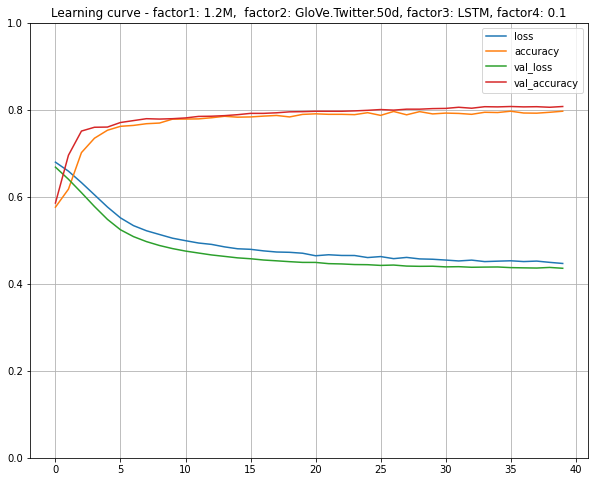

In [174]:

# Plot the learning curve
pd.DataFrame(history9.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 1.2M,  factor2: GloVe.Twitter.50d, factor3: LSTM, factor4: 0.1')
plt.show()

# Prepare the test data

In [175]:
test_sequences = tokenizer.texts_to_sequences(test_text)
padded_seq = keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen)
X_test = padded_seq
X_test.shape

(3263, 31)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [176]:
predict9 = model9.predict_classes(X_test)
predict9


array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [177]:
len(predict9)

3263

In [178]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict9)})
submission_df.to_csv('submission_rnn_9.csv',index=False)


In [179]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #9', 
                                   'vocabulary size (factor1)':'1.2M',
                                   'pre-trained vector dimensions (factor2)':'GloVe.Twitter.50d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78976'
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608
8,RNN #9,1.2M,GloVe.Twitter.50d,LSTM layer based,0.1,0 days 00:06:03.038276,0.7970,0.8078,0.78976


# Fit RNN 10
# vocabulary size (factor 1): 1.2M
# pre-trained vector dimensions (factor 2): GloVe.Twitter.50d
# rnn structure (factor 3): LSTM layer based structure
# dropout (factor 4): 0.3

In [180]:
model10 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [181]:
model10.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 31, 50)            577050    
_________________________________________________________________
lstm_10 (LSTM)               (None, 31, 128)           91648     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 720,219
Trainable params: 143,169
Non-trainable params: 577,050
_________________________________________________________________


In [182]:
opt=Adam(learning_rate=1e-5)
model10.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [183]:
# Fit the model; obtain the model fit time
start=datetime.now()
history10 = model10.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 9s 55ms/step - loss: 0.6788 - accuracy: 0.5772 - val_loss: 0.6675 - val_accuracy: 0.5893
Epoch 2/40
167/167 [==============================] - 9s 52ms/step - loss: 0.6632 - accuracy: 0.6095 - val_loss: 0.6472 - val_accuracy: 0.6349
Epoch 3/40
167/167 [==============================] - 9s 52ms/step - loss: 0.6443 - accuracy: 0.6575 - val_loss: 0.6218 - val_accuracy: 0.7185
Epoch 4/40
167/167 [==============================] - 9s 52ms/step - loss: 0.6223 - accuracy: 0.7108 - val_loss: 0.5916 - val_accuracy: 0.7636
Epoch 5/40
167/167 [==============================] - 9s 53ms/step - loss: 0.5974 - accuracy: 0.7416 - val_loss: 0.5625 - val_accuracy: 0.7662
Epoch 6/40
167/167 [==============================] - 9s 53ms/step - loss: 0.5728 - accuracy: 0.7515 - val_loss: 0.5372 - val_accuracy: 0.7701
Epoch 7/40
167/167 [==============================] - 9s 53ms/step - loss: 0.5495 - accuracy: 0.7602 - val_loss: 0.5199 - val_accuracy: 0.7688

In [184]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history10.history['accuracy'][np.argmin(history10.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.7863

In [185]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history10.history['val_accuracy'][np.argmin(history10.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.7912

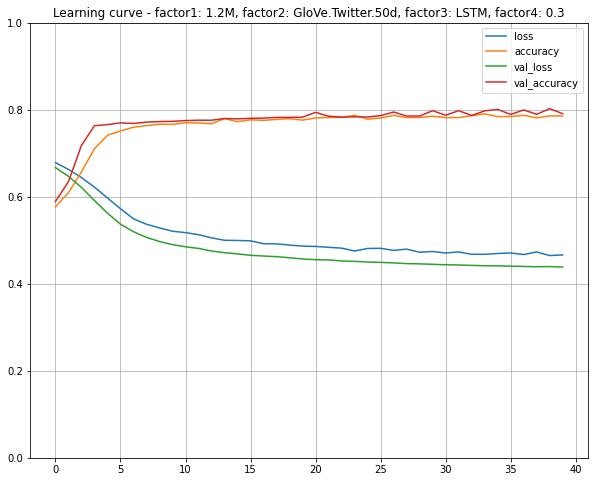

In [186]:
# Plot the learning curve
pd.DataFrame(history10.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 1.2M, factor2: GloVe.Twitter.50d, factor3: LSTM, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier 

In [187]:
X_test.shape

(3263, 31)

In [188]:
X_test

array([[   0,    0,    0, ..., 1781,  119,   85],
       [   0,    0,    0, ...,  594, 1863,  218],
       [   0,    0,    0, ...,  326,   90,   39],
       ...,
       [   0,    0,    0, ...,  333,    3, 1192],
       [   0,    0,    0, ...,  435,  228, 1598],
       [   0,    0,    0, ..., 1471,   71,  251]], dtype=int32)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [189]:

predict10 = model10.predict_classes(X_test)
predict10

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [190]:
len(predict10)

3263

In [191]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict10)})
submission_df.to_csv('submission_rnn_10.csv',index=False)

In [192]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #10', 
                                   'vocabulary size (factor1)':'1.2M',
                                   'pre-trained vector dimensions (factor2)':'GloVe.Twitter.50d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.77965'
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608
8,RNN #9,1.2M,GloVe.Twitter.50d,LSTM layer based,0.1,0 days 00:06:03.038276,0.7970,0.8078,0.78976
9,RNN #10,1.2M,GloVe.Twitter.50d,LSTM layer based,0.3,0 days 00:06:30.106538,0.7863,0.7912,0.77965


# Fit RNN 11
# vocabulary size (factor 1): 1.2M
# pre-trained vector dimensions (factor 2): GloVe.Twitter.50d
# rnn structure (factor 3): GRU layer based structure
# dropout (factor 4): 0.1

In [193]:
model11 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [194]:
model11.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 31, 50)            577050    
_________________________________________________________________
gru_8 (GRU)                  (None, 31, 128)           69120     
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 685,531
Trainable params: 108,481
Non-trainable params: 577,050
_________________________________________________________________


In [195]:
opt=Adam(learning_rate=1e-5)
model11.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)


In [196]:
# Fit the model; obtain the model fit time
start=datetime.now()
history11 = model11.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 8s 49ms/step - loss: 0.7001 - accuracy: 0.4845 - val_loss: 0.6734 - val_accuracy: 0.6519
Epoch 2/40
167/167 [==============================] - 8s 47ms/step - loss: 0.6712 - accuracy: 0.6367 - val_loss: 0.6528 - val_accuracy: 0.6848
Epoch 3/40
167/167 [==============================] - 8s 48ms/step - loss: 0.6537 - accuracy: 0.6688 - val_loss: 0.6343 - val_accuracy: 0.7145
Epoch 4/40
167/167 [==============================] - 9s 51ms/step - loss: 0.6399 - accuracy: 0.6786 - val_loss: 0.6159 - val_accuracy: 0.7342
Epoch 5/40
167/167 [==============================] - 9s 52ms/step - loss: 0.6248 - accuracy: 0.6949 - val_loss: 0.5958 - val_accuracy: 0.7443
Epoch 6/40
167/167 [==============================] - 8s 48ms/step - loss: 0.6078 - accuracy: 0.7074 - val_loss: 0.5750 - val_accuracy: 0.7500
Epoch 7/40
167/167 [==============================] - 8s 46ms/step - loss: 0.5935 - accuracy: 0.7200 - val_loss: 0.5552 - val_accuracy: 0.7574

In [197]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history11.history['accuracy'][np.argmin(history11.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.7955

In [198]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history11.history['val_accuracy'][np.argmin(history11.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.8082

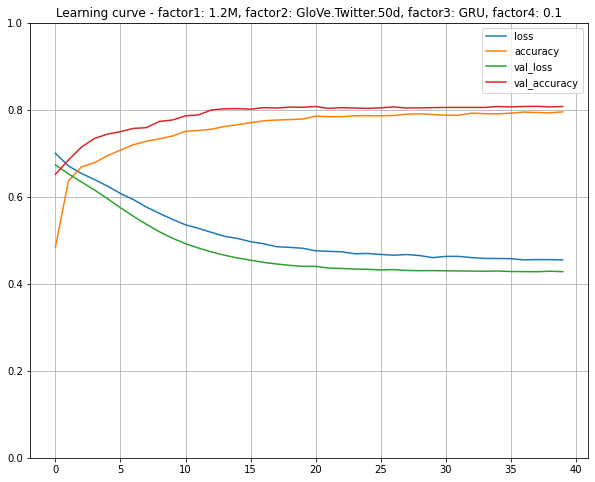

In [199]:
# Plot the learning curve
pd.DataFrame(history11.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 1.2M, factor2: GloVe.Twitter.50d, factor3: GRU, factor4: 0.1')
plt.show()

# Re-use the X_test obtained earlier

In [200]:
X_test

array([[   0,    0,    0, ..., 1781,  119,   85],
       [   0,    0,    0, ...,  594, 1863,  218],
       [   0,    0,    0, ...,  326,   90,   39],
       ...,
       [   0,    0,    0, ...,  333,    3, 1192],
       [   0,    0,    0, ...,  435,  228, 1598],
       [   0,    0,    0, ..., 1471,   71,  251]], dtype=int32)

In [201]:
X_test.shape

(3263, 31)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [202]:

predict11 = model11.predict_classes(X_test)
predict11

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [203]:

len(predict3)

3263

In [204]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict11)})
submission_df.to_csv('submission_rnn_11.csv',index=False)


In [205]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #11', 
                                   'vocabulary size (factor1)':'1.2M',
                                   'pre-trained vector dimensions (factor2)':'GloVe.Twitter.50d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78792'
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608
8,RNN #9,1.2M,GloVe.Twitter.50d,LSTM layer based,0.1,0 days 00:06:03.038276,0.7970,0.8078,0.78976
9,RNN #10,1.2M,GloVe.Twitter.50d,LSTM layer based,0.3,0 days 00:06:30.106538,0.7863,0.7912,0.77965


# Fit RNN 12
# vocabulary size (factor 1): 1.2M
# pre-trained vector dimensions (factor 2): GloVe.Twitter.50d
# rnn structure (factor 3): GRU based structure
# dropout (factor 4): 0.3

In [206]:

model12 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,50,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [207]:
model12.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 31, 50)            577050    
_________________________________________________________________
gru_10 (GRU)                 (None, 31, 128)           69120     
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                37248     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 685,531
Trainable params: 108,481
Non-trainable params: 577,050
_________________________________________________________________


In [208]:

opt=Adam(learning_rate=1e-5)
model12.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)


In [209]:
# Fit the model; obtain the model fit time
start=datetime.now()
history12 = model12.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)


Epoch 1/40
167/167 [==============================] - 8s 45ms/step - loss: 0.7051 - accuracy: 0.4980 - val_loss: 0.6928 - val_accuracy: 0.5455
Epoch 2/40
167/167 [==============================] - 7s 43ms/step - loss: 0.6810 - accuracy: 0.5658 - val_loss: 0.6690 - val_accuracy: 0.5687
Epoch 3/40
167/167 [==============================] - 7s 43ms/step - loss: 0.6684 - accuracy: 0.5832 - val_loss: 0.6481 - val_accuracy: 0.6309
Epoch 4/40
167/167 [==============================] - 7s 43ms/step - loss: 0.6535 - accuracy: 0.6288 - val_loss: 0.6292 - val_accuracy: 0.6909
Epoch 5/40
167/167 [==============================] - 7s 43ms/step - loss: 0.6394 - accuracy: 0.6536 - val_loss: 0.6108 - val_accuracy: 0.7224
Epoch 6/40
167/167 [==============================] - 7s 43ms/step - loss: 0.6257 - accuracy: 0.6832 - val_loss: 0.5931 - val_accuracy: 0.7373
Epoch 7/40
167/167 [==============================] - 7s 42ms/step - loss: 0.6118 - accuracy: 0.6919 - val_loss: 0.5762 - val_accuracy: 0.7439

In [210]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history12.history['accuracy'][np.argmin(history12.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.7834

In [211]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history12.history['val_accuracy'][np.argmin(history12.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.8025

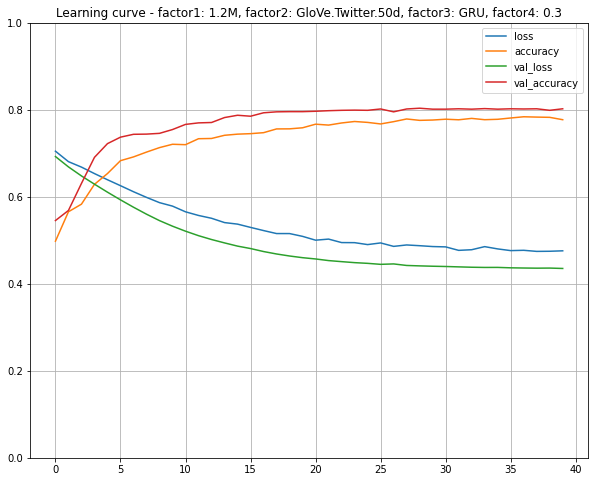

In [212]:
# Plot the learning curve
pd.DataFrame(history12.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 1.2M, factor2: GloVe.Twitter.50d, factor3: GRU, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier

In [213]:
X_test

array([[   0,    0,    0, ..., 1781,  119,   85],
       [   0,    0,    0, ...,  594, 1863,  218],
       [   0,    0,    0, ...,  326,   90,   39],
       ...,
       [   0,    0,    0, ...,  333,    3, 1192],
       [   0,    0,    0, ...,  435,  228, 1598],
       [   0,    0,    0, ..., 1471,   71,  251]], dtype=int32)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [214]:
predict12 = model12.predict_classes(X_test)
predict12


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [215]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict12)})
submission_df.to_csv('submission_rnn_12.csv',index=False)

In [216]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #12', 
                                   'vocabulary size (factor1)':'1.2M',
                                   'pre-trained vector dimensions (factor2)':'GloVe.Twitter.50d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78210'
                                   },ignore_index=True)
results_tbl


,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608
8,RNN #9,1.2M,GloVe.Twitter.50d,LSTM layer based,0.1,0 days 00:06:03.038276,0.7970,0.8078,0.78976
9,RNN #10,1.2M,GloVe.Twitter.50d,LSTM layer based,0.3,0 days 00:06:30.106538,0.7863,0.7912,0.77965


## Read the Glove file - glove.twitter.27B.200d.txt

In [217]:

#reading from the file to learn the word embedding into the list word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/harini-mac/Desktop/Northwestern University/MSDS-422/Week8/project1/nlp-getting-started/embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt')


In [218]:
len(word_to_index)

1193514

In [219]:
len(word_to_vec_map)

1193514

In [220]:
len(index_to_word)

1193514

## Cleanse the training and test data 
## Use the word_to_vec_map from glove.twitter.200d

In [221]:
for i in range (train_tweets.shape[0]):
    train_tweets.at[i,'text']=clean(train_tweets.loc[i,'text'])
    
for i in range(test_tweets.shape[0]):
    test_tweets.at[i,'text']=clean(test_tweets.loc[i,'text'])

In [222]:
train_text = train_tweets['text']
test_text = test_tweets['text']

# Encode the text in the training data
# Pad the resultant sequences

In [223]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [224]:
train_sequences = tokenizer.texts_to_sequences(train_text)

In [225]:
tokenizer.texts_to_sequences(["Forest fire near La Ronge Sask. Canada"])

[[175, 42, 208, 649, 5804, 5805, 1279]]

In [226]:
tokenizer.sequences_to_texts([[175, 42, 208, 649, 5804, 5805, 1279]])

['forest fire near la ronge sask canada']

In [227]:
word2index = tokenizer.word_index
print("Number of unique tokens : ",len(word2index))

Number of unique tokens :  11540


In [228]:

dataset_size = tokenizer.document_count
dataset_size


7613

In [229]:
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
maxlen

31

In [230]:
padded_seq = keras.preprocessing.sequence.pad_sequences(train_sequences,maxlen)
X_train = padded_seq
Y_train = train_tweets['target']
X_train.shape

(7613, 31)

# Generate embedding matrix for tokens in the training data - 200 Dimensions


In [231]:
embedding_matrix = np.zeros((len(word2index)+1,200))

embedding_vec=[]
for word, i in word2index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        embedding_matrix[i] = embedding_vec

In [232]:
print(embedding_matrix[1])

[ 4.9350e-01  3.5698e-01  6.6068e-01 -3.2975e-02  2.4989e-01  2.5936e-01
 -2.7169e-02  6.8403e-02 -2.9063e-01 -4.5705e-01 -7.7940e-02  3.2516e-01
 -1.4852e+00 -6.7472e-02 -1.7033e-01 -9.2964e-03  3.4628e-01 -1.1575e-02
  3.7965e-02  4.5617e-01  8.0486e-02  1.5310e-01 -1.5309e-01 -1.8810e-01
 -1.8195e-01  8.7245e-01  3.9792e-01  4.0995e-01  4.4982e-01 -1.9651e-03
 -4.1124e-02 -4.7867e-02 -2.4045e-01 -8.6883e-02  1.4180e-02 -2.3760e-01
  2.5183e-01  2.8551e-01  4.4504e-01 -4.9644e-01 -1.2709e-01 -1.7476e-01
  8.2196e-02  4.5409e-02  5.1720e-01  3.4546e-02 -8.5822e-02 -3.4924e-01
  5.2215e-01 -3.9510e-01  6.4123e-02 -4.2020e-01 -1.5943e-01  1.8283e-01
 -5.7885e-02 -1.9182e-02 -4.4547e-01  3.1542e-01 -1.6096e-01 -9.2139e-02
 -2.4960e-01 -1.3897e-03 -4.2643e-01 -1.7932e-01  8.1654e-02  1.8324e-01
 -3.2065e-01 -1.2009e-04 -1.3095e-01 -2.9812e-01 -2.5144e-03 -1.1318e-01
 -4.6378e-01 -1.9960e-01  8.5100e-01 -6.8009e-02  1.2870e-01 -6.7256e-01
 -1.2225e-02  1.4201e-01  9.2478e-01  8.5156e-02  2

In [233]:
print(embedding_matrix.shape)

(11541, 200)


# Fit RNN 13
# vocabulary size (factor 1): 1.2M
# pre-trained vector dimensions (factor 2): GloVe.Twitter.200d
# rnn structure (factor 3): LSTM layer based structure
# dropout (factor 4): 0.1

In [234]:
model13 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])


In [235]:
model13.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 31, 200)           2308200   
_________________________________________________________________
lstm_12 (LSTM)               (None, 31, 128)           168448    
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 2,528,169
Trainable params: 219,969
Non-trainable params: 2,308,200
_________________________________________________________________


In [236]:
opt=Adam(learning_rate=1e-5)
model13.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)


In [237]:
# Fit the model; obtain the model fit time
start=datetime.now()
history13 = model13.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 11s 66ms/step - loss: 0.6863 - accuracy: 0.5592 - val_loss: 0.6645 - val_accuracy: 0.6957
Epoch 2/40
167/167 [==============================] - 10s 60ms/step - loss: 0.6537 - accuracy: 0.6906 - val_loss: 0.6285 - val_accuracy: 0.7237
Epoch 3/40
167/167 [==============================] - 10s 60ms/step - loss: 0.6186 - accuracy: 0.7257 - val_loss: 0.5869 - val_accuracy: 0.7605
Epoch 4/40
167/167 [==============================] - 10s 60ms/step - loss: 0.5813 - accuracy: 0.7517 - val_loss: 0.5471 - val_accuracy: 0.7688
Epoch 5/40
167/167 [==============================] - 10s 61ms/step - loss: 0.5492 - accuracy: 0.7636 - val_loss: 0.5195 - val_accuracy: 0.7715
Epoch 6/40
167/167 [==============================] - 10s 60ms/step - loss: 0.5244 - accuracy: 0.7748 - val_loss: 0.4991 - val_accuracy: 0.7758
Epoch 7/40
167/167 [==============================] - 10s 61ms/step - loss: 0.5098 - accuracy: 0.7713 - val_loss: 0.4869 - val_accuracy:

In [238]:

print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history13.history['accuracy'][np.argmin(history13.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8159

In [239]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history13.history['val_accuracy'][np.argmin(history13.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.7942

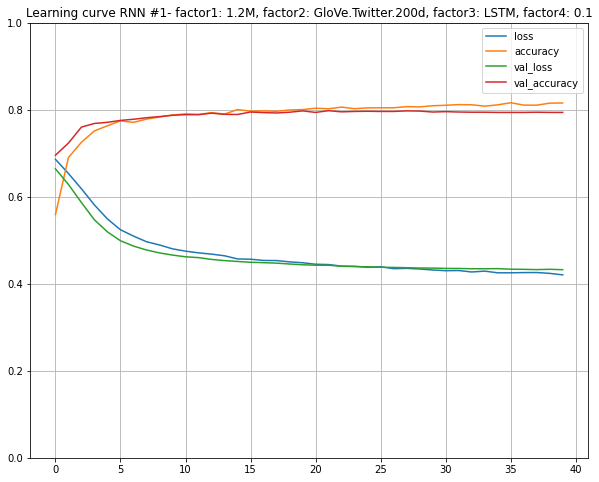

In [240]:
# Plot the learning curve
pd.DataFrame(history13.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve RNN #1- factor1: 1.2M, factor2: GloVe.Twitter.200d, factor3: LSTM, factor4: 0.1')
plt.show()

# Prepare the test data

In [241]:
test_sequences = tokenizer.texts_to_sequences(test_text)
padded_seq = keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen)
X_test = padded_seq
X_test.shape


(3263, 31)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [242]:

predict13 = model13.predict_classes(X_test)
predict13

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [243]:
len(predict13)

3263

In [244]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict13)})
submission_df.to_csv('submission_rnn_13.csv',index=False)

In [245]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #13', 
                                   'vocabulary size (factor1)':'1.2M',
                                   'pre-trained vector dimensions (factor2)':'GloVe.Twitter.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.79313'
                                   },ignore_index=True)
results_tbl



,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608
8,RNN #9,1.2M,GloVe.Twitter.50d,LSTM layer based,0.1,0 days 00:06:03.038276,0.7970,0.8078,0.78976
9,RNN #10,1.2M,GloVe.Twitter.50d,LSTM layer based,0.3,0 days 00:06:30.106538,0.7863,0.7912,0.77965


# Fit RNN 14
# vocabulary size (factor 1): 1.2M
# pre-trained vector dimensions (factor 2): GloVe.Twitter.200d
# rnn structure (factor 3): LSTM layer based structure
# dropout (factor 4): 0.3

In [246]:
model14 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.LSTM(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])


In [247]:
model14.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 31, 200)           2308200   
_________________________________________________________________
lstm_14 (LSTM)               (None, 31, 128)           168448    
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 2,528,169
Trainable params: 219,969
Non-trainable params: 2,308,200
_________________________________________________________________


In [248]:

opt=Adam(learning_rate=1e-5)
model14.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [249]:
# Fit the model; obtain the model fit time
start=datetime.now()
history14 = model14.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)


Epoch 1/40
167/167 [==============================] - 9s 56ms/step - loss: 0.6886 - accuracy: 0.5271 - val_loss: 0.6695 - val_accuracy: 0.6090
Epoch 2/40
167/167 [==============================] - 9s 54ms/step - loss: 0.6640 - accuracy: 0.6268 - val_loss: 0.6428 - val_accuracy: 0.6607
Epoch 3/40
167/167 [==============================] - 9s 54ms/step - loss: 0.6438 - accuracy: 0.6733 - val_loss: 0.6114 - val_accuracy: 0.7281
Epoch 4/40
167/167 [==============================] - 9s 55ms/step - loss: 0.6181 - accuracy: 0.7146 - val_loss: 0.5793 - val_accuracy: 0.7548
Epoch 5/40
167/167 [==============================] - 9s 55ms/step - loss: 0.5918 - accuracy: 0.7356 - val_loss: 0.5503 - val_accuracy: 0.7623
Epoch 6/40
167/167 [==============================] - 9s 56ms/step - loss: 0.5652 - accuracy: 0.7515 - val_loss: 0.5251 - val_accuracy: 0.7723
Epoch 7/40
167/167 [==============================] - 9s 55ms/step - loss: 0.5473 - accuracy: 0.7517 - val_loss: 0.5076 - val_accuracy: 0.7723

In [250]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history14.history['accuracy'][np.argmin(history14.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8003

In [251]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history14.history['val_accuracy'][np.argmin(history14.history['val_loss'])],4)
best_model_val_accuracy

Best Validation Accuracy: 


0.792

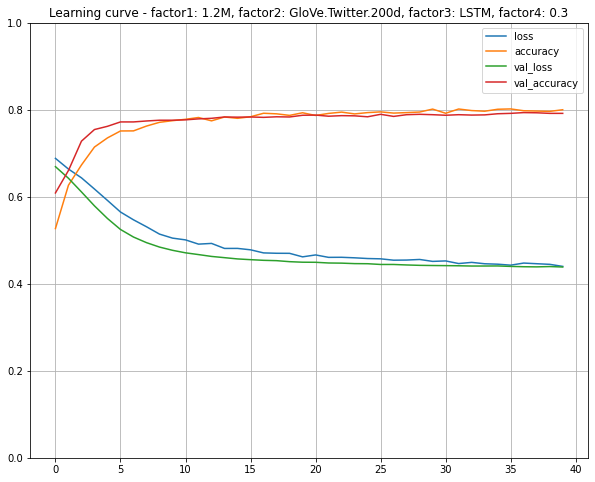

In [252]:
# Plot the learning curve
pd.DataFrame(history14.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 1.2M, factor2: GloVe.Twitter.200d, factor3: LSTM, factor4: 0.3')
plt.show()


# Re-use the X_test obtained earlier 

In [253]:
X_test.shape

(3263, 31)

In [254]:
X_test

array([[   0,    0,    0, ..., 1781,  119,   85],
       [   0,    0,    0, ...,  594, 1863,  218],
       [   0,    0,    0, ...,  326,   90,   39],
       ...,
       [   0,    0,    0, ...,  333,    3, 1192],
       [   0,    0,    0, ...,  435,  228, 1598],
       [   0,    0,    0, ..., 1471,   71,  251]], dtype=int32)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [255]:
predict14 = model14.predict_classes(X_test)
predict14


array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [256]:
len(predict14)

3263

In [257]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict14)})
submission_df.to_csv('submission_rnn_14.csv',index=False)

In [258]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #14', 
                                   'vocabulary size (factor1)':'1.2M',
                                   'pre-trained vector dimensions (factor2)':'GloVe.Twitter.200d',
                                   'RNN structure (factor3)':'LSTM layer based',
                                   'hyperparameter dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78639'
                                   },ignore_index=True)
results_tbl



,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608
8,RNN #9,1.2M,GloVe.Twitter.50d,LSTM layer based,0.1,0 days 00:06:03.038276,0.7970,0.8078,0.78976
9,RNN #10,1.2M,GloVe.Twitter.50d,LSTM layer based,0.3,0 days 00:06:30.106538,0.7863,0.7912,0.77965


# Fit RNN 15
# vocabulary size (factor 1): 1.2M
# pre-trained vector dimensions (factor 2): GloVe.Twitter.200d
# rnn structure (factor 3): GRU layer based structure
# dropout (factor 4): 0.1

In [259]:
model15 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])


In [260]:
model15.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 31, 200)           2308200   
_________________________________________________________________
gru_12 (GRU)                 (None, 31, 128)           126720    
_________________________________________________________________
gru_13 (GRU)                 (None, 64)                37248     
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 2,474,281
Trainable params: 166,081
Non-trainable params: 2,308,200
_________________________________________________________________


In [261]:

opt=Adam(learning_rate=1e-5)
model15.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [262]:
# Fit the model; obtain the model fit time
start=datetime.now()
history15 = model15.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 9s 52ms/step - loss: 0.6782 - accuracy: 0.5755 - val_loss: 0.6696 - val_accuracy: 0.5933
Epoch 2/40
167/167 [==============================] - 8s 49ms/step - loss: 0.6589 - accuracy: 0.6153 - val_loss: 0.6457 - val_accuracy: 0.6440
Epoch 3/40
167/167 [==============================] - 8s 50ms/step - loss: 0.6385 - accuracy: 0.6579 - val_loss: 0.6210 - val_accuracy: 0.6909
Epoch 4/40
167/167 [==============================] - 8s 49ms/step - loss: 0.6191 - accuracy: 0.6904 - val_loss: 0.5976 - val_accuracy: 0.7167
Epoch 5/40
167/167 [==============================] - 8s 50ms/step - loss: 0.6013 - accuracy: 0.7086 - val_loss: 0.5759 - val_accuracy: 0.7342
Epoch 6/40
167/167 [==============================] - 8s 49ms/step - loss: 0.5825 - accuracy: 0.7279 - val_loss: 0.5564 - val_accuracy: 0.7465
Epoch 7/40
167/167 [==============================] - 8s 49ms/step - loss: 0.5684 - accuracy: 0.7333 - val_loss: 0.5396 - val_accuracy: 0.7526

In [263]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history15.history['accuracy'][np.argmin(history15.history['loss'])],4)
best_model_train_accuracy

Best Train Accuracy: 


0.8129

In [264]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history15.history['val_accuracy'][np.argmin(history15.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.7933

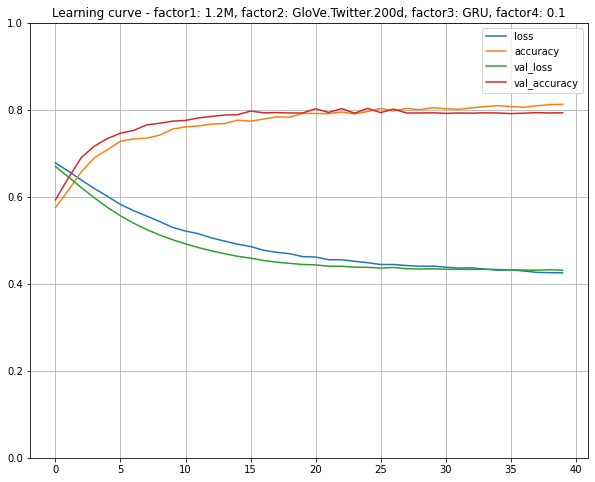

In [265]:

# Plot the learning curve
pd.DataFrame(history15.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 1.2M, factor2: GloVe.Twitter.200d, factor3: GRU, factor4: 0.1')
plt.show()

 # Re-use the X_test obtained earlier

In [266]:
X_test

array([[   0,    0,    0, ..., 1781,  119,   85],
       [   0,    0,    0, ...,  594, 1863,  218],
       [   0,    0,    0, ...,  326,   90,   39],
       ...,
       [   0,    0,    0, ...,  333,    3, 1192],
       [   0,    0,    0, ...,  435,  228, 1598],
       [   0,    0,    0, ..., 1471,   71,  251]], dtype=int32)

In [267]:
X_test.shape

(3263, 31)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [268]:
predict15 = model15.predict_classes(X_test)
predict15

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [269]:
len(predict15)

3263

In [270]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict15)})
submission_df.to_csv('submission_rnn_15.csv',index=False)

In [271]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #15', 
                                   'vocabulary size (factor1)':'1.2M',
                                   'pre-trained vector dimensions (factor2)':'GloVe.Twitter.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter dropout (factor4)': '0.1',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.78976'
                                   },ignore_index=True)
results_tbl

,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608
8,RNN #9,1.2M,GloVe.Twitter.50d,LSTM layer based,0.1,0 days 00:06:03.038276,0.7970,0.8078,0.78976
9,RNN #10,1.2M,GloVe.Twitter.50d,LSTM layer based,0.3,0 days 00:06:30.106538,0.7863,0.7912,0.77965


# Fit RNN 16
# vocabulary size (factor 1): 1.2M
# pre-trained vector dimensions (factor 2): GloVe.Twitter.200d
# rnn structure (factor 3): GRU based structure
# dropout (factor 4): 0.3

In [272]:
model16 = keras.models.Sequential([
    keras.layers.Embedding(len(word2index)+1,200,weights=[embedding_matrix],input_length=maxlen,trainable=False),
    keras.layers.GRU(units=128 , return_sequences = True , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.GRU(units=64 , recurrent_dropout = 0.3 , dropout = 0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])


In [273]:
model16.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 31, 200)           2308200   
_________________________________________________________________
gru_14 (GRU)                 (None, 31, 128)           126720    
_________________________________________________________________
gru_15 (GRU)                 (None, 64)                37248     
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 2,474,281
Trainable params: 166,081
Non-trainable params: 2,308,200
_________________________________________________________________


In [274]:

opt=Adam(learning_rate=1e-5)
model16.compile(
  loss='binary_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],
)

In [275]:
# Fit the model; obtain the model fit time
start=datetime.now()
history16 = model16.fit(X_train,Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_split=0.3
)
end=datetime.now()
print(end-start)

Epoch 1/40
167/167 [==============================] - 9s 53ms/step - loss: 0.6912 - accuracy: 0.5232 - val_loss: 0.6824 - val_accuracy: 0.5845
Epoch 2/40
167/167 [==============================] - 8s 51ms/step - loss: 0.6761 - accuracy: 0.6014 - val_loss: 0.6668 - val_accuracy: 0.6134
Epoch 3/40
167/167 [==============================] - 8s 50ms/step - loss: 0.6651 - accuracy: 0.6181 - val_loss: 0.6503 - val_accuracy: 0.6576
Epoch 4/40
167/167 [==============================] - 8s 51ms/step - loss: 0.6518 - accuracy: 0.6495 - val_loss: 0.6325 - val_accuracy: 0.6848
Epoch 5/40
167/167 [==============================] - 9s 54ms/step - loss: 0.6408 - accuracy: 0.6656 - val_loss: 0.6144 - val_accuracy: 0.7141
Epoch 6/40
167/167 [==============================] - 9s 54ms/step - loss: 0.6263 - accuracy: 0.6851 - val_loss: 0.5962 - val_accuracy: 0.7412
Epoch 7/40
167/167 [==============================] - 9s 56ms/step - loss: 0.6117 - accuracy: 0.7099 - val_loss: 0.5783 - val_accuracy: 0.7482

In [276]:
print ('Best Train Accuracy: ')
best_model_train_accuracy = np.round(history16.history['accuracy'][np.argmin(history16.history['loss'])],4)
best_model_train_accuracy


Best Train Accuracy: 


0.799

In [277]:
print ('Best Validation Accuracy: ')
best_model_val_accuracy = np.round(history16.history['val_accuracy'][np.argmin(history16.history['val_loss'])],4)
best_model_val_accuracy


Best Validation Accuracy: 


0.8104

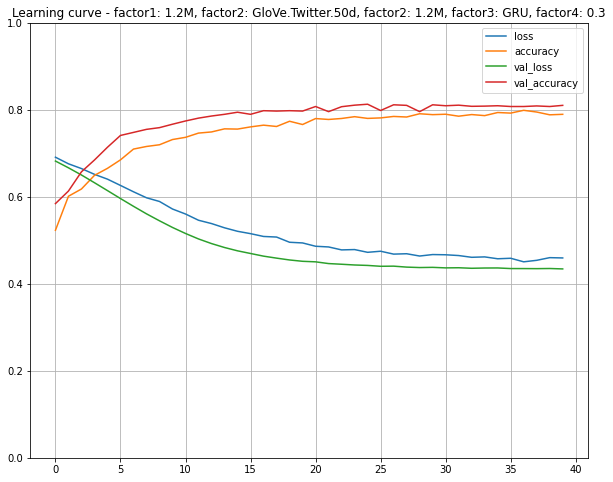

In [278]:
# Plot the learning curve
pd.DataFrame(history16.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.title('Learning curve - factor1: 1.2M, factor2: GloVe.Twitter.50d, factor2: 1.2M, factor3: GRU, factor4: 0.3')
plt.show()

# Re-use the X_test obtained earlier

In [279]:
X_test

array([[   0,    0,    0, ..., 1781,  119,   85],
       [   0,    0,    0, ...,  594, 1863,  218],
       [   0,    0,    0, ...,  326,   90,   39],
       ...,
       [   0,    0,    0, ...,  333,    3, 1192],
       [   0,    0,    0, ...,  435,  228, 1598],
       [   0,    0,    0, ..., 1471,   71,  251]], dtype=int32)

# Make the prediction on the test data
# 1 - disaster tweet , 0 - non-disaster tweet

In [280]:

predict16 = model16.predict_classes(X_test)
predict16

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [281]:
# save the results to a csv
submission_df = pd.DataFrame({'id':test_tweets['id'],'target':np.squeeze(predict16)})
submission_df.to_csv('submission_rnn_16.csv',index=False)

In [282]:
#Store the accuracy and kaggle score for this model 
results_tbl = results_tbl.append({'Model_name':'RNN #16', 
                                   'vocabulary size (factor1)':'1.2M',
                                   'pre-trained vector dimensions (factor2)':'GloVe.Twitter.200d',
                                   'RNN structure (factor3)':'GRU layer based',
                                   'hyperparameter dropout (factor4)': '0.3',
                                   'Processing Time':(end-start),
                                   'Training Set Accuracy':best_model_train_accuracy,
                                   'Validation Set Accuracy':best_model_val_accuracy,
                                   'Test Set F1-score (Kaggle score)': '0.79497'
                                   },ignore_index=True)
results_tbl



,Model_name,vocabulary size (factor1),pre-trained vector dimensions (factor2),RNN structure (factor3),hyperparameter dropout (factor4),Processing Time,Training Set Accuracy,Validation Set Accuracy,Test Set F1-score (Kaggle score)
0,RNN #1,400K,GloVe.6B.50d,LSTM layer based,0.1,0 days 00:05:57.975295,0.7940,0.8030,0.78087
1,RNN #2,400K,GloVe.6B.50d,LSTM layer based,0.3,0 days 00:05:58.567337,0.7865,0.7995,0.78026
2,RNN #3,400K,GloVe.6B.50d,GRU layer based,0.1,0 days 00:04:48.108696,0.7964,0.8043,0.78302
3,RNN #4,400K,GloVe.6B.50d,GRU layer based,0.3,0 days 00:05:08.302466,0.7861,0.8034,0.77873
4,RNN #5,400K,GloVe.6B.200d,LSTM layer based,0.1,0 days 00:08:01.728722,0.8194,0.8084,0.79313
5,RNN #6,400K,GloVe.6B.200d,LSTM layer based,0.3,0 days 00:06:46.279831,0.8000,0.8130,0.78639
6,RNN #7,400K,GloVe.6B.200d,GRU layer based,0.1,0 days 00:06:13.773095,0.8127,0.7947,0.79068
7,RNN #8,400K,GloVe.6B.200d,GRU layer based,0.3,0 days 00:05:56.381758,0.7919,0.8008,0.78608
8,RNN #9,1.2M,GloVe.Twitter.50d,LSTM layer based,0.1,0 days 00:06:03.038276,0.7970,0.8078,0.78976
9,RNN #10,1.2M,GloVe.Twitter.50d,LSTM layer based,0.3,0 days 00:06:30.106538,0.7863,0.7912,0.77965


In [283]:
results_tbl.to_csv('submission_stats.csv')